# Data Preparation

In [33]:
# import basic modules
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm, tqdm_pandas
import matplotlib.pyplot as plt
%matplotlib inline


plt.style.use('bmh')

In [34]:
# import dataset
train = pd.read_csv("../dataset/train.csv")
# train = pd.read_csv("../dataset/train_feats_init.csv")

In [35]:
print("Training data: ", train.shape)

Training data:  (404290, 6)
Test data:  (2345796, 3)


In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


There are 2 records with null `question2` field on training set, we'll observe the records' content.

In [37]:
train[(train['question2'].isnull())]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


It seems that both questions are actually duplicate pair, but for now we'll replace them with empty string and trust the `is_duplicate` label.

**UPDATE: to improve our training set, we'll set the pairs as is_duplicate = 1 (see Data Augmentation section)**

In [38]:
print("Fill null values with empty string...")
train['question1'].fillna('', inplace=True)
train['question2'].fillna('', inplace=True)

Fill null values with empty string...


In [42]:
train.head(3)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


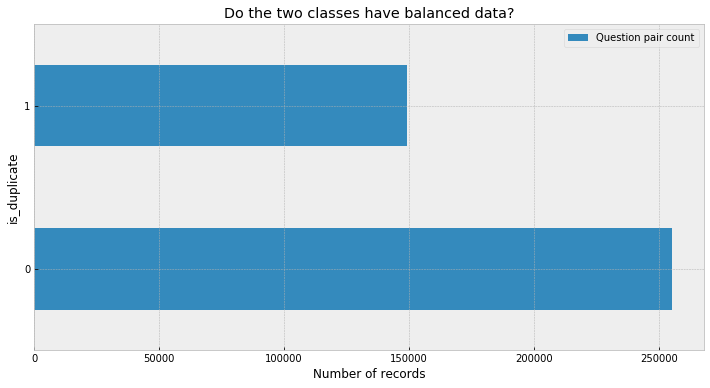

In [43]:
f, ax = plt.subplots(figsize=(12,6))
train.groupby('is_duplicate').agg({'id': 'count'}).reset_index().sort_values(by='id',ascending=False).plot(kind='barh', ax=ax, x='is_duplicate', y='id')
ax.legend(['Question pair count'])
ax.set_title("Do the two classes have balanced data?")
ax.set_xlabel("Number of records")
plt.show();

In [44]:
train_agg = train.groupby('is_duplicate').agg({'id': 'count'}).reset_index().rename(columns={'id':'count'})
train_agg['pct'] = 100.00 * train_agg['count'] / np.sum(train_agg['count'])
train_agg

,is_duplicate,count,pct
0,0,255025,63.07972
1,1,149265,36.92028


We have rather imbalanced dataset here.

# Data Augmentation

Purpose: add 50% of duplicate records for duplicate class, so the dataset will have more balanced class.
We will replace *question1* to its synonyms.

In [52]:
duplicate_qid = []

for ix, row in train[(train['is_duplicate'] == 1)].iterrows():
    duplicate_qid.append(row['id'])

In [100]:
augmented_qid = []
for i in range(0, np.int64(np.round(len(duplicate_qid) * 0.5))):
    augmented_qid.append(np.random.choice(duplicate_qid, replace=False))
    
augmented_df = pd.DataFrame(columns=['id','qid1','qid2','question1','question2','is_duplicate'])
for i in augmented_qid:
    augmented_df = augmented_df.append(train[(train['id'] == i)])

In [149]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

question1_syn = []

for ix, row in augmented_df.iterrows():
    words = word_tokenize(row['question1'])
    tagged = nltk.pos_tag(words)
    output = ''

    for i in range(0,len(words)):
        replacements = []

        # Only replace nouns with nouns, vowels with vowels etc.
        for syn in wordnet.synsets(words[i]):

            # Do not attempt to replace proper nouns or determiners or conjunctions or WH-pronoun
            if tagged[i][1] == 'NNP' or tagged[i][1] == 'DT' or tagged[i][1] == 'CC' or tagged[i][1] == 'WP':
                break

            # The tokenizer returns strings like NNP, VBP etc
            # but the wordnet synonyms has tags like .n.
            # So we extract the first character from NNP ie n
            # then we check if the dictionary word has a .n. or not 
            word_type = tagged[i][1][0].lower()
            if syn.name().find("."+word_type+"."):
                # extract the word only
                r = syn.name()[0:syn.name().find(".")]
                replacements.append(r)

        if len(replacements) > 0:
            # Choose a random replacement
            replacement = replacements[np.random.randint(0,len(replacements))]
            output = output + " " + replacement
        else:
            # If no replacement could be found, then just use the
            # original word
            output = output + " " + words[i]

    question1_syn.append(output)

In [150]:
augmented_df['question1_bak'] = augmented_df['question1']
augmented_df['question1'] = question1_syn

In [154]:
augmented_df.tail(3)

,id,qid1,qid2,question1,question2,is_duplicate,question1_bak
171176,171176,264544,264545,What be some common idea that buttocks resolv...,What are some ideas that can solve the regular...,1,What are some common ideas that can solve the ...
64318,64318,111781,111782,What perform `` net worth '' entail ?,What does net worth mean?,1,"What does ""net worth"" mean?"
217667,217667,18758,2921,How effective be quarrel five_hundred and tho...,Would demonetization of 500 and 1000 rupee not...,1,How effective is scrapping 500 and 1000 rupee ...


In [153]:
train_augment = train.copy()
train_augment = train_augment.append(augmented_df)

In [ ]:
# repair the label of those 2 questions with empty question2
q1_text = {}

for ix, row in train_augment[(train_augment['question2'] == '')].iterrows():
    q1_text[row['id']] = (row['question1'])

for key, value in q1_text.items():
    train_augment['question2'] = train_augment.apply(lambda x: value if (x['question2'] == '') & (x['id'] != key) else x['question2'], axis=1)
    train_augment['is_duplicate'] = train_augment.apply(lambda x: 1 if (x['id'] == key) else x['is_duplicate'], axis=1)

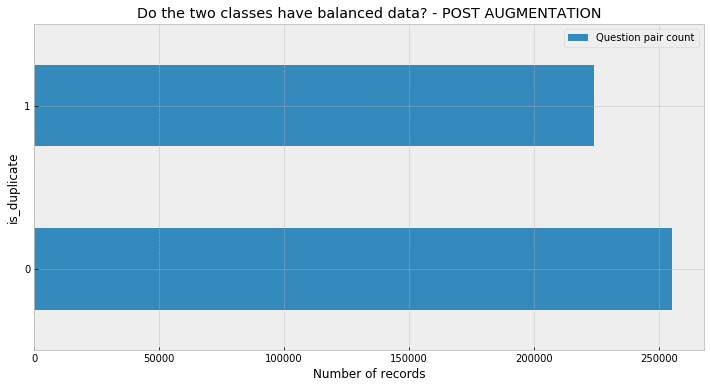

In [156]:
f, ax = plt.subplots(figsize=(12,6))
train_augment.groupby('is_duplicate').agg({'id': 'count'}).reset_index().sort_values(by='id',ascending=False).plot(kind='barh', ax=ax, x='is_duplicate', y='id')
ax.legend(['Question pair count'])
ax.set_title("Do the two classes have balanced data? - POST AUGMENTATION")
ax.set_xlabel("Number of records")
plt.show();

In [157]:
train_agg = train_augment.groupby('is_duplicate').agg({'id': 'count'}).reset_index().rename(columns={'id':'count'})
train_agg['pct'] = 100.00 * train_agg['count'] / np.sum(train_agg['count'])
train_agg

,is_duplicate,count,pct
0,0,255025,53.249799
1,1,223897,46.750201


# Feature Extraction

Some codes below can be changed from `train` to `train_augment`, according to the extracted object.

### 1. TF-IDF

In [158]:
import re

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    return text

In [159]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

import spacy
nlp = spacy.load('en')

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [161]:
qid_dict = {}

for i,series in train.iterrows():
# for i,series in train_augment.iterrows():
    if series['qid1'] not in qid_dict:
        qid_dict[series['qid1']] = series['question1']
    if series['qid2'] not in qid_dict:
        qid_dict[series['qid2']] = series['question2']

In [162]:
txt_raw = []

for key, value in qid_dict.items():
    txt_raw.append(str(value))

In [163]:
txt = []
for i in range(0, len(txt_raw)):
    txt.append(text_to_word_list(txt_raw[i]))

In [169]:
# get tfidf value
vectorizer = TfidfVectorizer(min_df=10, max_features=1000000, tokenizer=word_tokenize, ngram_range=(1,1))
vz = vectorizer.fit(txt)

q1 = vz.transform(train['question1'])
q2 = vz.transform(train['question2'])

# q1 = vz.transform(train_augment['question1'])
# q2 = vz.transform(train_augment['question2'])

/home/engineering/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


### 2. Get distance metrics between each question pair

- Cosine distance
- Jaccard distance
- Levenshtein distance for first and last word on question pair

In [171]:
# count occurence of each word on every question
# will be used to calculate cosine distance

count_vectorizer = CountVectorizer(min_df=10, ngram_range=(1,1))
cvz = count_vectorizer.fit(txt)

q1_ct = cvz.transform(train['question1'])
q2_ct = cvz.transform(train['question2'])
# q1_ct = cvz.transform(train_augment['question1'])
# q2_ct = cvz.transform(train_augment['question2'])

In [172]:
# calculate cosine distance
from sklearn.metrics.pairwise import paired_cosine_distances

dist = paired_cosine_distances(q1_ct, q2_ct)

train['cosine_dist'] = dist
# train_augment['cosine_dist'] = dist

In [173]:
def jaccard_dist(str1, str2):
    str1 = set(str1.split())
    str2 = set(str2.split())
    return float(len(str1 & str2)) / len(str1 | str2)

train['jaccard_dist'] = train.apply(lambda x: jaccard_dist(x['question1'],x['question2']), axis=1)
# train_augment['jaccard_dist'] = train_augment.apply(lambda x: jaccard_dist(x['question1'],x['question2']), axis=1)

In [174]:
from nltk.metrics import edit_distance

train['edit_dist_first_word'] = train.apply(lambda x: edit_distance(x['question1'].split()[0], x['question2'].split()[0]) if (x['question1'] != '' and x['question2'] != '') else 999, axis=1)
train['edit_dist_last_word'] = train.apply(lambda x: edit_distance(x['question1'].split()[-1], x['question2'].split()[-1]) if (x['question1'] != '' and x['question2'] != '') else 999, axis=1)

# train_augment['edit_dist_first_word'] = train_augment.apply(lambda x: edit_distance(x['question1'].split()[0], x['question2'].split()[0]) if (x['question1'] != '' and x['question2'] != '') else 999, axis=1)
# train_augment['edit_dist_last_word'] = train_augment.apply(lambda x: edit_distance(x['question1'].split()[-1], x['question2'].split()[-1]) if (x['question1'] != '' and x['question2'] != '') else 999, axis=1)

### 3. Get sentence characteristics

- word count
- unique word count
- sentence count
- common words between question pair

In [177]:
train['question1_wc'] = train['question1'].apply(lambda sent: len(sent.split()))
train['question2_wc'] = train['question2'].apply(lambda sent: len(sent.split()))

# train_augment['question1_wc'] = train_augment['question1'].apply(lambda sent: len(sent.split()))
# train_augment['question2_wc'] = train_augment['question2'].apply(lambda sent: len(sent.split()))

In [178]:
train['diff_wc'] = abs(train['question1_wc'] - train['question2_wc'])
# train_augment['diff_wc'] = abs(train_augment['question1_wc'] - train_augment['question2_wc'])

In [179]:
# extract unique words

from string import punctuation

def unique_words(sentence):
    for punc in punctuation:
        sentence = sentence.replace(punc,'')
    return [w for w in set(sentence.lower().split())]

In [180]:
train['question1_unique_wc'] = train['question1'].apply(lambda sent: len(unique_words(sent)))
train['question2_unique_wc'] = train['question2'].apply(lambda sent: len(unique_words(sent)))

# train_augment['question1_unique_wc'] = train_augment['question1'].apply(lambda sent: len(unique_words(sent)))
# train_augment['question2_unique_wc'] = train_augment['question2'].apply(lambda sent: len(unique_words(sent)))

In [181]:
train['diff_unique_wc'] = abs(train['question1_unique_wc'] - train['question2_unique_wc'])

# train_augment['diff_unique_wc'] = abs(train_augment['question1_unique_wc'] - train_augment['question2_unique_wc'])

In [182]:
import re

def count_sentences(question):
    count = 0
    for sentence in re.split(r'[.!?]+', question):
        if sentence == '':
            continue
        else:
            count += 1
    return count

In [183]:
train['question1_sc'] = train['question1'].apply(lambda q: count_sentences(q))
train['question2_sc'] = train['question2'].apply(lambda q: count_sentences(q))

# train_augment['question1_sc'] = train_augment['question1'].apply(lambda q: count_sentences(q))
# train_augment['question2_sc'] = train_augment['question2'].apply(lambda q: count_sentences(q))

In [184]:
train['question1_word_list'] = train.apply(lambda x: set(x['question1'].split()), axis=1)
train['question2_word_list'] = train.apply(lambda x: set(x['question2'].split()), axis=1)

train['common_words'] = train.apply(lambda x: x['question1_word_list'].intersection(x['question2_word_list']), axis=1)
train['num_common_words'] = train.apply(lambda x: len(x['common_words']), axis=1)

# train_augment['question1_word_list'] = train_augment.apply(lambda x: set(x['question1'].split()), axis=1)
# train_augment['question2_word_list'] = train_augment.apply(lambda x: set(x['question2'].split()), axis=1)

# train_augment['common_words'] = train_augment.apply(lambda x: x['question1_word_list'].intersection(x['question2_word_list']), axis=1)
# train_augment['num_common_words'] = train_augment.apply(lambda x: len(x['common_words']), axis=1)

### 4. Extract Named Entity Recognition (NER)

From the extracted NERs, we'll observe the sentence characteristics.

NERs of augmented training set is assumed to be similar to the preset text (since it is only replaced by its synonym), so we don't need to run the code for augmented training set.

In [185]:
def process_ner(doc):
    result = []
    
    if type(doc) == list:
        for row in doc:
            tmp = str(row)
            if len(row.ents) > 0:
                for entity in row.ents:
                    tmp = tmp.replace(entity.text, entity.label_)
                result.append(tmp)
            else:
                result.append(tmp)
                continue
    return result

In [192]:
train_q1 = train['question1'].tolist()
train_q2 = train['question2'].tolist()
# train_augment_q1 = train_augment['question1'].tolist()
# train_augment_q2 = train_augment['question2'].tolist()


doc_train_q1 = []
doc_train_q2 = []

for i in range(0, len(train_q1)):
    try:
        doc_train_q1.append(nlp(train_q1[i]))
        doc_train_q2.append(nlp(train_q2[i]))
    except Exception as e:
        print(e)
        break
        
# for i in range(0, len(train_augment_q1)):
#     try:
#         doc_train_q1.append(nlp(train_augment_q1[i]))
#         doc_train_q2.append(nlp(train_augment_q2[i]))
#     except Exception as e:
#         print(e)
#         break

In [193]:
train['question1_ner'] = process_ner(doc_train_q1)
train['question2_ner'] = process_ner(doc_train_q2)

# train_augment['question1_ner'] = process_ner(doc_train_q1)
# train_augment['question2_ner'] = process_ner(doc_train_q2)

In [194]:
train['question1_word_list_ner'] = train.apply(lambda x: set(x['question1_ner'].split()), axis=1)
train['question2_word_list_ner'] = train.apply(lambda x: set(x['question2_ner'].split()), axis=1)

train['common_words_ner'] = train.apply(lambda x: x['question1_word_list_ner'].intersection(x['question2_word_list_ner']), axis=1)
train['num_common_words_ner'] = train.apply(lambda x: len(x['common_words_ner']), axis=1)

# train_augment['question1_word_list_ner'] = train_augment.apply(lambda x: set(x['question1_ner'].split()), axis=1)
# train_augment['question2_word_list_ner'] = train_augment.apply(lambda x: set(x['question2_ner'].split()), axis=1)

# train_augment['common_words_ner'] = train_augment.apply(lambda x: x['question1_word_list_ner'].intersection(x['question2_word_list_ner']), axis=1)
# train_augment['num_common_words_ner'] = train_augment.apply(lambda x: len(x['common_words_ner']), axis=1)

In [196]:
train['pct_common_words'] = train.apply(lambda x: x['num_common_words'] / np.max(x[['question1_unique_wc','question2_unique_wc']]) * 100, axis=1)
train['pct_common_words_ner'] = train.apply(lambda x: x['num_common_words_ner'] / np.max(x[['question1_unique_wc','question2_unique_wc']]) * 100, axis=1)

# train_augment['pct_common_words'] = train_augment.apply(lambda x: x['num_common_words'] / np.max(x[['question1_unique_wc','question2_unique_wc']]) * 100, axis=1)
# train_augment['pct_common_words_ner'] = train_augment.apply(lambda x: x['num_common_words_ner'] / np.max(x[['question1_unique_wc','question2_unique_wc']]) * 100, axis=1)

### 5. Use Part-of-Speech (POS) tagging

We will calculate occurence of each part of speech within question pairs.

POS tag of augmented training set is assumed to be similar to the preset text (since it is only replaced by its synonym), so we don't need to run the code for augmented training set.

In [197]:
pos_list = ['NOUN','VERB','PUNCT','SYM','X','ADJ','CONJ','NUM','DET','ADV','ADP','PROPN','PART','SPACE','INTJ']

def calculate_pos_tag(doc):
    result = []
    for row in doc:
        # initialize empty value for each row 
        pos_tmp = {}
        for idx in pos_list:
            pos_tmp[idx] = 0
            
        for token in row:
            if token.pos_ in pos_tmp:
                pos_tmp[token.pos_] += 1
        result.append(pos_tmp)
    return result

In [198]:
q1_pos_tag = calculate_pos_tag(doc_train_q1)
q2_pos_tag = calculate_pos_tag(doc_train_q2)

In [ ]:
def convert_pos_tag(pos_tag_list):
    tags = []
    for i in range(0, len(pos_tag_list)):
        tmp = []
        for key, value in pos_tag_list[i].items():
            tmp.append(value)
        tags.append(tmp)
    return np.array(tags)

In [ ]:
q1_tag = convert_pos_tag(q1_pos_tag)
q2_tag = convert_pos_tag(q2_pos_tag)

In [ ]:
_q1_pos_tag = []
_q2_pos_tag = []

for i in range(0, len(train)):
# for i in range(0, len(train_augment)):
    _q1_pos_tag.append(q1_tag[i])
    _q2_pos_tag.append(q2_tag[i])
               
train['q1_pos_tag'] = _q1_pos_tag
train['q2_pos_tag'] = _q2_pos_tag

# train_augment['q1_pos_tag'] = _q1_pos_tag
# train_augment['q2_pos_tag'] = _q2_pos_tag

In [ ]:
# Save
# np.save('data/preset/q1_pos_tag.npy', q1_pos_tag) 
# np.save('data/preset/q2_pos_tag.npy', q2_pos_tag) 

# np.save('data/augmented/q1_pos_tag.npy', q1_pos_tag) 
# np.save('data/augmented/q2_pos_tag.npy', q2_pos_tag) 

In [215]:
# write collected features to csv
# train.to_csv(path_or_buf="../dataset/train_feats_init.csv", header=True, index=False)

# alternative to save preprocessed augmented data without getting the NER & POS tag by running the code:
# assuming the NER and POS tag will be similar to the default training set
# train = pd.read_csv("../dataset/train_feats_init.csv")
train_augmented = train_augment.merge(
    train[['id','qid1','qid2','question1_ner','question2_ner',
                   'question1_word_list_ner','question2_word_list_ner','common_words_ner',
                   'num_common_words_ner','pct_common_words_ner','q1_pos_tag','q2_pos_tag']],
    how='left',
    on=['id','qid1','qid2']
)

train_augmented.to_csv(path_or_buf="../dataset/train_augmented.csv", header=True, index=False)

**Use GLOVE word embedding**

In [201]:
import csv, json
from zipfile import ZipFile
from os.path import expanduser, exists

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.data_utils import get_file

/home/engineering/anaconda2/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [213]:
KERAS_DATASETS_DIR = expanduser('~/.keras/datasets/')
GLOVE_ZIP_FILE_URL = 'http://nlp.stanford.edu/data/glove.840B.300d.zip'
GLOVE_ZIP_FILE = 'glove.840B.300d.zip'
GLOVE_FILE = 'glove.840B.300d.txt'

dataset_type = 'preset' # value: preset or augmented

Q1_TRAINING_DATA_FILE = 'data/' + dataset_type + '/q1_train.npy'
Q2_TRAINING_DATA_FILE = 'data/' + dataset_type + '/q2_train.npy'
LABEL_TRAINING_DATA_FILE = 'data/' + dataset_type + '/label_train.npy'
WORD_EMBEDDING_MATRIX_FILE = 'data/' + dataset_type + '/word_embedding_matrix.npy'
NB_WORDS_DATA_FILE = 'data/' + dataset_type + '/nb_words.json'
MAX_NB_WORDS = 200000
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 300

In [204]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(txt)
question1_word_sequences = tokenizer.texts_to_sequences(train['question1'])
question2_word_sequences = tokenizer.texts_to_sequences(train['question2'])
# question1_word_sequences = tokenizer.texts_to_sequences(train_augment['question1'])
# question2_word_sequences = tokenizer.texts_to_sequences(train_augment['question2'])
word_index = tokenizer.word_index

print("Words in index: %d" % len(word_index))

Words in index: 85518


In [205]:
if not exists(KERAS_DATASETS_DIR + GLOVE_ZIP_FILE):
    zipfile = ZipFile(get_file(GLOVE_ZIP_FILE, GLOVE_ZIP_FILE_URL))
    zipfile.extract(GLOVE_FILE, path=KERAS_DATASETS_DIR)
    
print("Processing", GLOVE_FILE)

embeddings_index = {}
with open(KERAS_DATASETS_DIR + GLOVE_FILE, encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings: %d' % len(embeddings_index))

Processing glove.840B.300d.txt
Word embeddings: 2196016


In [206]:
nb_words = min(MAX_NB_WORDS, len(word_index))
word_embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector

print('Null word embeddings: %d' % np.sum(np.sum(word_embedding_matrix, axis=1) == 0))

Null word embeddings: 18731


In [207]:
q1_data = pad_sequences(question1_word_sequences, maxlen=MAX_SEQUENCE_LENGTH)
q2_data = pad_sequences(question2_word_sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = np.array(train_augment['is_duplicate'], dtype=int)
print('Shape of question1 data tensor:', q1_data.shape)
print('Shape of question2 data tensor:', q2_data.shape)
print('Shape of label tensor:', labels.shape)

Shape of question1 data tensor: (478922, 25)
Shape of question2 data tensor: (478922, 25)
Shape of label tensor: (404290,)


The word embeddings will be concatenated with other extracted features.

In [217]:
np.save(open(Q1_TRAINING_DATA_FILE, 'wb'), q1_data)
np.save(open(Q2_TRAINING_DATA_FILE, 'wb'), q2_data)
np.save(open(LABEL_TRAINING_DATA_FILE, 'wb'), labels)
np.save(open(WORD_EMBEDDING_MATRIX_FILE, 'wb'), word_embedding_matrix)
with open(NB_WORDS_DATA_FILE, 'w') as f:
    json.dump({'nb_words': nb_words}, f)